<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%EC%88%AB%EC%9E%90%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

OSError: ignored

In [7]:
from torch.autograd import functional
import tensorflow as tf
from fastai.vision.all import *
from fastbook import *
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### GPU 설정

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [9]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8859427797460936765
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13465944064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13368593622812596560
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


### 숫자 3과 7의 이미지 분류하는 모델

In [10]:
path = untar_data(URLs.MNIST_SAMPLE)

In [11]:
# 디렉터리 내용 확인
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [12]:
# 학습 데이터셋의 폴더 내용 확인
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [13]:
# 파일 순서가 같도록 정렬하기
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [14]:
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [15]:
# 손으로 쓴 숫자 3 이미지를 출력하기
img3_path = threes[1]
img3 = Image.open(img3_path)
img3

In [16]:
# 이미지를 구성하는 숫자 확인
array(img3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [17]:
# 텐서로 표현
tensor(img3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [18]:
# 판다스 데이터프레임으로
# 숫자의 값에 따라 색상을
# 그라데이션으로 입히는 방법 보여주기
img3_t = tensor(img3)
df = pd.DataFrame(img3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


#### 픽셀 유사성

In [19]:
# 텐서 목록으로 구성된 리스트 생성하기
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

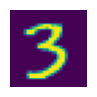

In [20]:
# 텐서 형태 이미지 출력하기
show_image(three_tensors[1]);

In [21]:
# 3차원 텐서(rank-3 tensor)로 결합하기
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [22]:
# 랭크 확인하기
len(stacked_threes.shape)

3

In [23]:
stacked_threes.ndim

3

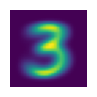

In [24]:
# 0번째 차원의 평균으로 모든 이미지 텐서의 평균 구하기
# 0번째 차원 : 이미지를 색인함.
mean3 = stacked_threes.mean(0)
show_image(mean3);

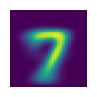

In [25]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

#### 거리 유사성 측정하기

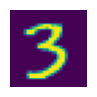

In [26]:
# 임의로 선택한 숫자3 샘플
a_3 = stacked_threes[1]
show_image(a_3);

In [27]:
# RMSE, MAD 모두 시행해보기
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [28]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [29]:
# 손실함수
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

#### 넘파이 배열과 파이토치 텐서

In [30]:
# 리스트로 배열/텐서 생성하기
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [31]:
# 넘파이
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [32]:
# 파이토치
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [33]:
tns[1]

tensor([4, 5, 6])

In [34]:
tns[:,1]

tensor([2, 5])

In [35]:
# 행/열의 일부분을 자유롭게 선택할 수 있음
tns[1,1:3]

tensor([5, 6])

In [36]:
# 표준 연산자
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [37]:
# 자료형 확인
tns.type()

'torch.LongTensor'

In [38]:
# 자료형 자동으로 바꾸기(정수>부동소수점)
tns * 1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

### 브로드캐스팅으로 평가지표 계산하기
- 브로드캐스팅 : 더 낮은 랭크의 텐서를 더 높은 텐서와 같은 크기로 자동 확장

In [39]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
# 크기(모양) 확인
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [40]:
# 평균절대오차를 계산하는 함수 구현
def mnist_distance(a,b) :
  return (a-b).abs().mean((-1,-2))

mnist_distance(a_3, mean3)

tensor(0.1114)

In [41]:
# 검증용 데이터셋 모두에 대해 거리 적용하기
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1590, 0.1102, 0.1366,  ..., 0.1344, 0.1599, 0.1160]),
 torch.Size([1010]))

In [42]:
# 브로드캐스팅 예시
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [43]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [44]:
# is_3() 구현하기
def is_3(x) :
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [45]:
# 실험해보기
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [46]:
# 검증용 데이터셋에서 실험
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True, False,  True])

In [47]:
# 정확도 계산하기
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### 확률적 경사 하강법

In [48]:
# 숫자 3이 될 확률
def pr_three(x,w) :
  return (x*w).sum()

#### 간단한 예시

In [49]:
# 2차 함수 정의
def f(x) :
  return x**2

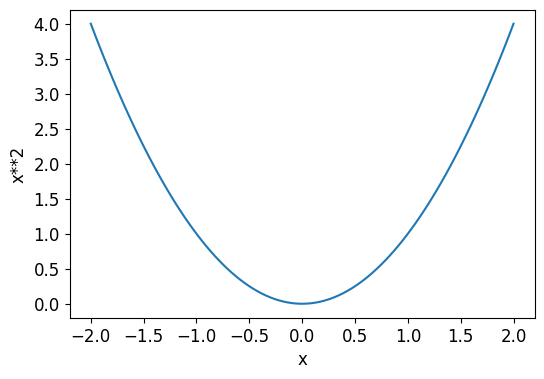

In [50]:
# 그래프 그리기
plot_function(f, 'x', 'x**2')

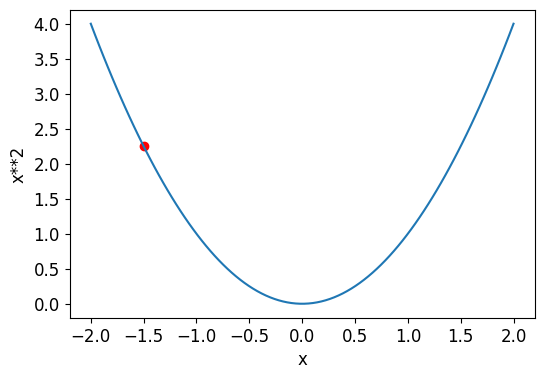

In [51]:
# 임의의 파라미터 값을 선택하고 손실값을 계산
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

#### 파이토치 자동미분

In [52]:
xt = tensor(3.).requires_grad_()

In [53]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [54]:
# 그레디언트 계산
yt.backward()

In [55]:
# 계산된 그레디언트 확인
xt.grad

tensor(6.)

In [56]:
# 벡터를 입력해서 그레디언트 구하기
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [57]:
# 벡터가 입력되었을 때 스칼라값을 출력하는 함수
def f(x) :
  return (x**2).sum()

In [58]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [59]:
# 그레디언트 구하기
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

#### SGD를 활용해보기

In [60]:
# 20초 동안 매초에 수작업으로 속력을 측정
time = torch.arange(0,20).float();
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

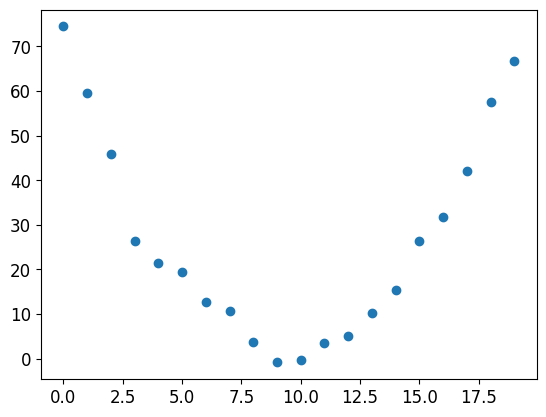

In [61]:
# 임의의 노이즈 추가
speed = torch.randn(20) * 3 + 0.75 * (time-9.5)**2 + 1
plt.scatter(time, speed);

In [62]:
# 모든 파라미터는 하나의 함수 인자로 담기
def f(t, params) :
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [63]:
# 손실 함수 정의
def mse(preds, targets) :
  return ((preds-targets)**2).mean().sqrt()

##### 1. 파라미터 초기화

In [64]:
params = torch.randn(3).requires_grad_()

##### 2. 예측 계산

In [65]:
preds = f(time, params)

In [66]:
# 예측과 실제 타깃의 유사도를 그래프로 그리는 함수
def show_preds(preds, ax=None) :
  if ax is None :
    ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)

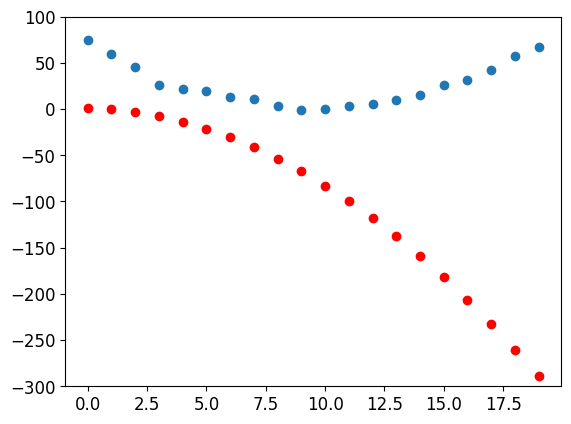

In [67]:
show_preds(preds)

##### 3. 손실 계산

In [68]:
loss = mse(preds, speed)
loss

tensor(160.6979, grad_fn=<SqrtBackward0>)

##### 4. 그레디언트 계산

In [69]:
loss.backward()
params.grad

tensor([-165.5151,  -10.6402,   -0.7900])

In [70]:
# 학습률 적용 : 계산된 그레디언트로 파라미터 개선
params.grad * 1e-5

tensor([-1.6552e-03, -1.0640e-04, -7.8996e-06])

In [71]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

##### 5. 가중치를 한 단계 계산하기

In [72]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [73]:
# 손실 개선 확인하기
preds = f(time, params)
mse(preds, speed)

tensor(160.4228, grad_fn=<SqrtBackward0>)

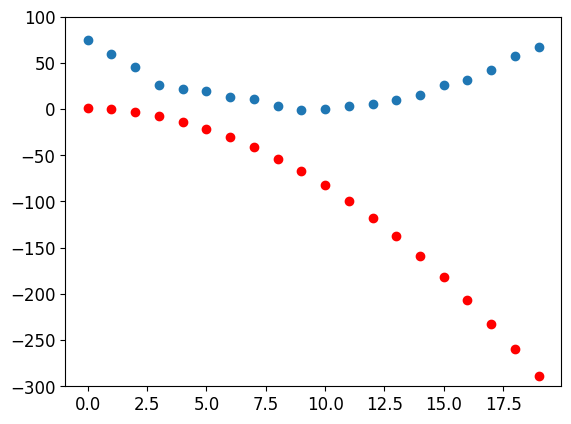

In [74]:
show_preds(preds)

In [75]:
# 모든 과정을 담은 함수 만들기
def apply_step(params, prn=True) :
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= params.grad.data
  params.grad = None
  if prn :
    print(loss.item())
  return preds

##### 6. 과정 반복하기

In [76]:
for i in range(10) :
  apply_step(params)

160.42279052734375
27717.353515625
532.9634399414062
27683.748046875
566.5306396484375
27654.02734375
596.2177124023438
27627.21484375
623.0078735351562
27602.669921875


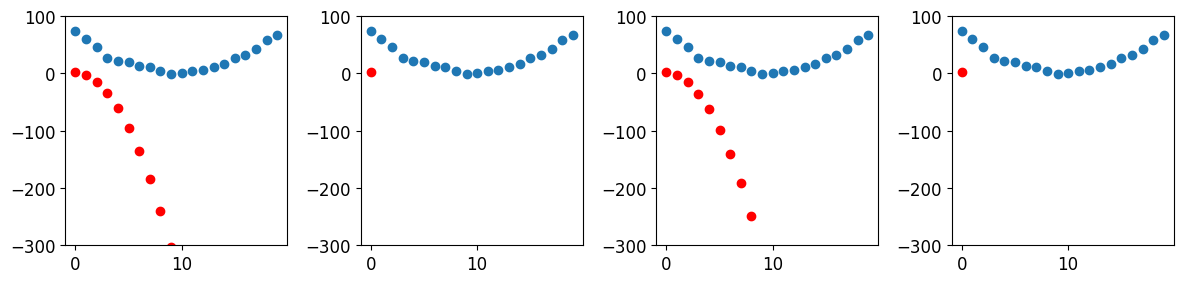

In [77]:
# 시각화
_, axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs :
  show_preds(apply_step(params, False), ax)
plt.tight_layout()

### MNIST 손실함수

In [78]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [79]:
# 각 이미지의 레이블(3:1, 7:0)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [80]:
# zip()함수를 list와 함께 사용하면 튜플을 간단히 구성할 수 있음.
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [81]:
# 검증용 데이터
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [82]:
valid_dset = list(zip(valid_x, valid_y))

In [83]:
# 각 픽셀에 임의로 초기화된 가중치가 필요함
def init_params(size, std=1.0) :
  return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))

In [84]:
# 편향(b)초기화
bias = init_params(1)

In [85]:
# 단일 이미지에 대한 예측
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [86]:
# 행렬곱셈 시행
def linear1(xb) :
  return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

In [87]:
# 정확도 검사
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [88]:
corrects.float().mean().item()

0.49080348014831543

In [89]:
# 가중치의 변화
# 기울기 계산을 비활성화한 후 가중치 업데이트
with torch.no_grad() :
  weights[0] *= 1.0001

In [90]:
preds = linear1(train_x)
((preds>0.5).float() == train_y).float().mean().item()

0.49080348014831543

In [91]:
# 손실함수 입력값
trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])

In [92]:
# 예측값-실제값 사이 거리 측정하는 함수
def mnist_loss(predictions, targets) :
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [93]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [94]:
mnist_loss(prds, trgts)

tensor(0.4333)

In [95]:
# 거짓 타겟 예측을 0.8로 바꿔보기
mnist_loss(tensor([0.9,0.4,0.8]), trgts)

tensor(0.2333)

#### 시그모이드

In [96]:
# 시그모이드 함수 정의
def sigmoid(x) :
  return 1/(1+torch.exp(-x))

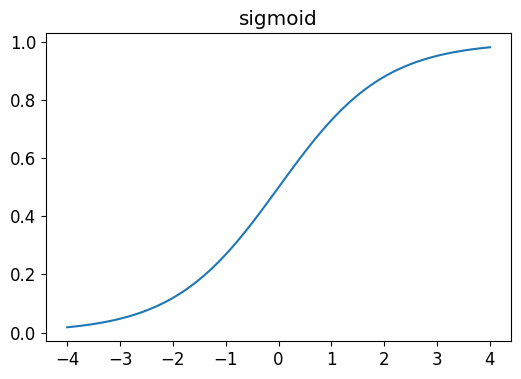

In [97]:
# 시그모이드 함수 그래프
plot_function(torch.sigmoid, title='sigmoid', min=-4, max=4)

In [98]:
# 앞선 함수에서 시그모이드 적용해보기
def mnist_loss(predictions, targets) :
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

#### SGD와 미니배치

In [99]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [100]:
# Dataset : 독립변수/종속변수 쌍을 다룸
# Dataset 예시
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [101]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

### 경사 하강의 과정

In [102]:
# 매 에포크에 구현되어야 할 과정
# for x,y in dl :
#   pred = model(x)
#   loss = loss_func(pred, y)
#   loss.backward()
#   parameters -= parameters.grad * lr

In [103]:
# 파라미터 초기화하기
weights = init_params((28*28, 1))
bias = init_params(1)

In [104]:
# first() : 객체에서 첫번째 배치를 가져옴
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [105]:
# 검증용 데이터셋
valid_dl = DataLoader(valid_dset, batch_size=256)

In [106]:
# 크기가 4인 미니배치를 만들어서 검사해보기
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [107]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [108]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

In [109]:
# 그레디언트 계산하기
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

In [110]:
# 구현 내용 하나의 함수로 만들기
def calc_grad(xb, yb, model) :
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [111]:
# 함수 검사해보기
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [112]:
# 이전 그레디언트 0으로 설정
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [113]:
# 한 에포크에서 수행되는 학습 루프
def train_epoch(model, lr, params) :
  for xb, yb in dl :
    calc_grad(xb, yb, model)
    for p in params :
      p.data -= p.grad*lr
      p.grad.zero_()

In [114]:
# 검증용 데이터셋
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

In [115]:
# 배치 단위의 평균 정확도를 계산하는 함수 만들기
def batch_accuracy(xb, yb) :
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [116]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [117]:
# 검증용 데이터셋의 모든 배치에 함수 적용하기
def validate_epoch(model) :
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [118]:
validate_epoch(linear1)

0.5264

In [119]:
# 한 에포크 동안 모델을 학습시킨 다음 정확도 개선 여부 확인하기
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

In [120]:
# 에포크 여러 번 반복하기
for i in range(20) :
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9275 0.9397 0.9466 0.9505 0.9524 0.9559 0.9578 0.9598 0.9608 0.9612 0.9618 0.9632 0.9637 0.9647 0.9657 0.9671 0.9676 

#### 옵티마이저 만들기

In [121]:
# nn.Linear로 모델 만들기
linear_model = nn.Linear(28*28,1)

In [122]:
# 파라미터 목록에 접근하기
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [123]:
# 파라미터 정보 활용하여 옵티마이저 정의하기
class BasicOptim :
  def __init__(self, params, lr) :
    self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs) :
    for p in self.params :
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs) :
    for p in self.params :
      p.grad = None

In [125]:
# 해당 옵티마이저 객체 생성하기
opt = BasicOptim(linear_model.parameters(), lr)

In [126]:
# 학습루프 간소화하기
def train_epoch(model) :
  for xb, yb in dl :
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [128]:
# 검증용 데이터셋의 정확도
validate_epoch(linear_model)

0.4606

In [129]:
# 학습 루프 및 검증용 데이터셋의 정확도 구하는 함수
def train_model(model, epochs) :
  for i in range(epochs) :
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [130]:
# 결과 확인
train_model(linear_model, 20)

0.4932 0.7686 0.8554 0.9136 0.9346 0.9482 0.957 0.9633 0.9658 0.9677 0.9697 0.9716 0.9736 0.9745 0.976 0.977 0.9775 0.9775 0.978 0.9785 

In [131]:
# fastai SGD클래스 : BasicOptim과 정확히 같은 방식으로 작동함
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model,20)

0.4932 0.855 0.8359 0.9111 0.9321 0.9462 0.955 0.9628 0.9658 0.9667 0.9692 0.9711 0.9731 0.9746 0.976 0.977 0.9775 0.9775 0.978 0.979 

##### Learner.fit()사용

In [132]:
# DataLoaders 생성
dls = DataLoaders(dl, valid_dl)

In [133]:
# Learner 생성하기
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [134]:
# fit메서드 호출
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636325,0.503246,0.495584,00:00
1,0.451432,0.236693,0.789500,00:00
2,0.168857,0.159305,0.858685,00:00
3,0.075659,0.099148,0.916585,00:00
4,0.041181,0.073948,0.936703,00:00
5,0.027617,0.059897,0.950442,00:00
6,0.021996,0.051021,0.956330,00:00
7,0.019468,0.045069,0.963199,00:00
8,0.018165,0.040868,0.965653,00:00
9,0.017368,0.037766,0.968106,00:00
